In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Download dataset

In [2]:
(X_train, Y_train), (X_val, Y_val) = tf.keras.datasets.boston_housing.load_data()

In [3]:
X_train.shape

(404, 13)

In [4]:
X_val.shape

(102, 13)

In [5]:
X_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

# Metric

Mean squared error seems to be a good one for this kind of problems

# Baseline

For this baseline the average could be a good choice

In [31]:
average_price = Y_val.mean()
error = (np.abs(Y_val-average_price)).mean()

In [35]:
print("Average price value:", average_price)
print("Baseline Mean Absoute Error (MAE):", error)

Average price value: 23.07843137254902
Baseline Mean Absoute Error (MAE): 6.5990003844675105


# Feature range

For the model to learn faster we need to keep each feature whithin the same range. Thus normalizing each one is a good idea. For this task we should substract the mean and divide by the standard deviation. Using only the training data.

In [8]:
#Calculate by feature axis=0 instead by row axis=1
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

In [9]:
X_train_norm = (X_train-mean_train)/std_train
X_val_norm = (X_val-mean_train)/std_train

In [10]:
X_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [11]:
X_train_norm[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [12]:
X_val_norm[0]

array([ 1.55369355, -0.48361547,  1.0283258 , -0.25683275,  1.03838067,
        0.23545815,  1.11048828, -0.93976936,  1.67588577,  1.5652875 ,
        0.78447637, -3.48459553,  2.25092074])

We only normalize the input value

# Model

For the model we could try a simple neural network

- loss: we can use SquareMeanError loss
- metric: Square mean error metric
- optimizer: rmsprop

In [13]:
def build_model():
    X_input = tf.keras.layers.Input(shape=X_train.shape[1])

    X = tf.keras.layers.Dense(activation='relu', units=64)(X_input)
    X = tf.keras.layers.Dense(activation='relu', units=64)(X)

    X_output = tf.keras.layers.Dense(units=1)(X)

    return tf.keras.Model(inputs=[X_input], outputs=[X_output])

In [14]:
model = build_model()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-03-31 21:05:22.999198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 21:05:22.999345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


# Compile the model

In [16]:
model.compile(loss="MSE", 
              metrics=["MAE"],
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-3)
            )

/Users/matiasgonzalez/miniforge3/envs/tf_2_9_metal_0_5_keras/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
EPOCS = 500

In [42]:
history = model.fit(X_train_norm, Y_train, epochs=EPOCS, batch_size=64, validation_data=(X_val_norm, Y_val), verbose=0)

In [19]:
def plot_loss_curves(history, epochs=30):
    epochs = range(1, epochs+1)
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.plot(train_loss, "r", label="train loss")
    plt.plot(val_loss, "b", label="val_loss")

    plt.title("Train vs Val Losses")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.legend()
    plt.show()

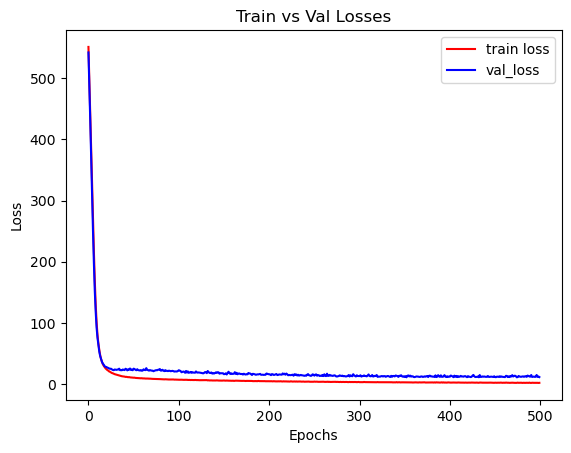

In [20]:
plot_loss_curves(history=history, epochs=EPOCS)

With 30 epochs is not able to beat the baseline with 1 one layer 32 units the same with 3 layers

Still the model can't beat the baseline error with -3^-16 which is almost zero. It seems to be a bias problem.

## Observation:

The fluctiation is noticiable in the val set that is because it's only 101 samples training data is also small the validation set is not diverse enough to be stable

# K-folds

Training using K-folds help us to avoid this problem and thus evaluating a model become esier.

In [21]:
from tqdm.auto import tqdm
import numpy as np

# K-Folds with K=4

## i will go from 0 to K-1 in this manner:
- fold 1 {0}[val]{1}[train]{2}[train]{3}[train]{4}
```First when i == 0 the range for validation is from 0 to 1. This is the offset by the number of elements in each slot.```
```First when i == 0 the range for train is from 1 to the end of the sequence. There is no lower limit this time.```
- fold 2 {0}[train]{1}[val]{2}[train]{3}[train]{4}
```First when i == 1 the range for validation is from 1 to 2. This is the offset by the number of elements in each slot.```
```First when i == 1 the range for train is divided in 2 parts this time first from 0 to 1 and the second from 2 to the end of the sequence.```
- fold 3 {0}[train]{1}[train]{2}[val]{3}[train]{4}
```First when i == 2 the range for validation is from 2 to 3. This is the offset by the number of elements in each slot.```
```First when i == 2 the range for train is divided in 2 parts this time first from 0 to 2 and the second from 3 to the end of the sequence.```
- fold 4 {0}[train]{1}[train]{2}[train]{3}[val]{4}
```First when i == 3 the range for validation is from 3 to 4. This is the offset by the number of elements in each slot.```
```First when i == 3 the range for train will not be divided in 2 parts this time, we only have 1 big block compose of 3 training blocks that goes from 3 up to the very begining of the set.```

In [22]:
K = 4
num_val_samples = X_train_norm.shape[0]//K
history_fold = []
evaluated_metrics_fold = []

for i in tqdm(range(K)):
    val_data_segment = X_train_norm[i*num_val_samples:(i+1)*num_val_samples]
    # When i == 0 is the first block
    # When i == K-1 this is the last block
    val_label_segment = Y_train[i*num_val_samples:(i+1)*num_val_samples]

    train_data_segment = np.concatenate([
        X_train_norm[:i*num_val_samples],
        #When i == 0 this is empty.
        #When i == K-1 this is all the blocks from the begining up to the begining of the last one
        X_train_norm[(i+1)*num_val_samples:]
        #When i == 0 is from the end of the first block up to the end.
        #When i == K-1 this is empty
    ], axis=0)

    train_label_segment = np.concatenate([
        Y_train[:i*num_val_samples],
        Y_train[(i+1)*num_val_samples:]
    ], axis=0)

    model = build_model()
    model.compile(loss="MSE", 
                metrics=["MAE"],
                optimizer=tf.keras.optimizers.RMSprop(lr=1e-3)
    )

    history = model.fit(train_data_segment, train_label_segment,
                        epochs=EPOCS,
                        batch_size=16,
                        validation_data=(val_data_segment, val_label_segment),
                        verbose=0
    )

    history_fold.append(history.history["val_loss"])

    # Returns the loss value & metrics values for the model in test mode.
    evaluated_metrics_fold.append(model.evaluate(val_data_segment, val_label_segment)[1])

    print(f"VAL MAE  fold {i+1} value: {model.evaluate(val_data_segment, val_label_segment)[1]}")
    print(f"TEST MAE fold {i+1} value: {model.evaluate(X_val_norm, Y_val)[1]}")

print(f"metric avg loss value mean: {np.array(evaluated_metrics_fold).mean()} in {K} folds")

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/matiasgonzalez/miniforge3/envs/tf_2_9_metal_0_5_keras/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
2023-03-31 21:05:56.336813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 21:05:56.734926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step - loss: 12.0943 - MAE: 2.4977
VAL MAE  fold 1 value: 2.4977128505706787
4/4 [==============================] - 0s 12ms/step - loss: 18.2581 - MAE: 2.8356
TEST MAE fold 1 value: 2.835606098175049


2023-03-31 21:07:10.214553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 21:07:10.617469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step - loss: 12.6611 - MAE: 2.4209
VAL MAE  fold 2 value: 2.4208850860595703
4/4 [==============================] - 0s 12ms/step - loss: 12.9703 - MAE: 2.5068
TEST MAE fold 2 value: 2.5067601203918457


2023-03-31 21:08:27.584621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 21:08:27.984302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step - loss: 13.8792 - MAE: 2.5288
VAL MAE  fold 3 value: 2.528809070587158
4/4 [==============================] - 0s 12ms/step - loss: 14.7424 - MAE: 2.4396
TEST MAE fold 3 value: 2.4395534992218018


2023-03-31 21:09:38.871877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 21:09:39.311527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step - loss: 15.4672 - MAE: 2.6087
VAL MAE  fold 4 value: 2.6087067127227783
4/4 [==============================] - 0s 13ms/step - loss: 15.3601 - MAE: 2.7157
TEST MAE fold 4 value: 2.7156834602355957
metric avg loss value mean: 2.5140284299850464 in 4 folds


In [44]:
6.59/2.5

2.636

# Conclusion
Our baseline was 6.599, using a 4-fold approach we got a MAE of 2.5 which is quite an improvement over the baseline of more than 2 times better

# Considerations
- The training set is quite small if we split it into training and validation, we will have a lot of variation every epoch when we evaluate the model against that small sample. In a way to solve this issue K-folds technique is the way to go at the end we do the average of the measures from each fold ending with a better approximation of how the mode performs on unseen data. At least we get a better sampling representation by doing that.
- The last layer does not have an activation function this is normal for this kind of problems scalar regression. In this way the model is free and not limit by the output of another function.
- When dealing with continues values data it is important to sacale the values that will make it easier for the model. By a different dispersion the model will need to adjust the weights more radical.